In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integ
import astropy.constants as cons
plt.rcParams.update({'font.size': 20})

# Problem 1

The electric field from an infinitesimally thin spherical shell of charge with radius R is found by integrating the fields produced by the rings along its central axis over the whole sphere. The integral is set up as shown below.

$$E_z = \frac{1}{4\pi\epsilon_0} \times (2\pi R^2 \sigma) \int^{\pi}_0 \frac{(z-Rcos\theta)sin\theta}{(R^2 + z^2 - 2Rzcos\theta)^{\frac{3}{2}}}d\theta$$

For the purpose of this problem, I set the surface charge $\sigma = 1$ and the radius of the sphere $R = 1$.

I now use my integrator (using simpson's rule) and the scipy quad integrator to find the electric field at a range of $z$ that goes from the inside to the outside of the shell and includes $z = R$.

In [2]:
def E(theta):
    '''Function to integrate over, representing the electric field of the charged thin shell'''
    factor = 1/(4*np.pi*cons.eps0) * 2*np.pi*R**2*sigma
    top = (z-R*np.cos(theta))*np.sin(theta)
    bottom = (R**2 + z**2 - 2*R*z*np.cos(theta))**(3/2)
    
    return top/bottom  

def simpsons(fun, a, b, N):
    """ Calculates integral of a function fun from a to b using Simpson's method
    Inputs:
    - fun: function to integrate over
    - a <float>: lower limit of the integral
    - b <float>: upper limit of the integral
    - N <int>: total number of slices

    Returns
    - estimated integral
    """
    # making sure we have even number of points
    if N%2==0:
        N=N+1
    dx = (b-a)/N # Calculating the slice width
    simpson = fun(a) + fun(b) # Adding the first and last terms 
    odd = 0
    even = 0
    # Now we add the even terms and odd terms together separately
    for k in range(1, N):
        if k%2 == 0:
            even += fun(a+k*dx)
        else:
            odd += fun(a+k*dx) 
    # combining even and odd terms to the first and last
    simpson += 4*odd + 2*even
    return dx/3*simpson

In [3]:
# setting up the values of constants
sigma = 1
R = 1

# creating range of zs that includes z = R
zs = np.linspace(0, R+1, 101)
N = 40

E_quad = []
E_simp = []
for z in zs:
    Q, _ = integ.quad(E, 0, np.pi)
    S = simpsons(E, 0, np.pi, N)
    E_quad.append(Q)
    E_simp.append(S)

/var/folders/rw/43dtvf4s1cg4s4rbh9cx59240000gn/T/ipykernel_27351/1138017236.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return top/bottom


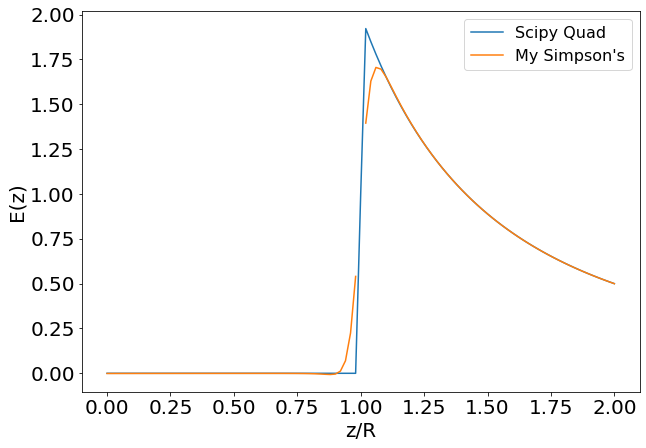

In [4]:
plt.figure(figsize=(10,7))
plt.plot(zs, E_quad, label='Scipy Quad')
plt.plot(zs, E_simp, label="My Simpson's")
plt.xlabel('z/R')
plt.ylabel('E(z)')
plt.legend(fontsize=16)
plt.show()

Looking at the results, we see there is definitely a singularity in the integral when $z = R$. This is shown as a very sharp line on the Scipy Quad calculations of the electric field. We see that scipy quad was not affected by the singularity. In fact, it managed to compute the integral correctly and did not even report a warning or struggle to run. My integrator, on the other hand, produced a warning message and certainly did care about the singularity. We see in the plot above that the calculation is missing values around the singularity at $z = R$.

We notice from this that scipy quad does function around singularities and if the results look sensible compared to what you would expected to be physically true, it is a good tool for dealing with singularities in integrals. 

# Problem 2

I wrote a recursive variable step size integrator using the basic structure of the one we used in class. In order to avoid calling $f(x)$ repeatedly for the same values of $x$, I stored the previous function calls in a dictionary, where each key, value pair represents an $x$ and its respective $f(x)$. I passed this dictionary on through the extra argument of my function so that further recursive calls would access it.

I tested the method for 3 different function integrations. The estimation for the integrals matched between the class example code and my function, however, there was a large difference in the number of function calls. 

For example, when integrating an offset gaussian function, my function saved 408 function calls compared to the lazy version. Similarly, for two rapidly oscillating functions, it saved 1176 and 174 calls. In general, for integrating functions that require a lot of splitting in the integration windows, it is very benefitial to use this method because it will save time and computing power by not calling functions unnecessarily. 

In [5]:
'''Functions to test'''

def offset_gauss(x):
    return 1+10*np.exp(-0.5*x**2/(0.1)**2)

def combine(x):
    return x**3*np.cos(x) - x**2*np.exp(-x) + 1

def sin_fun(x):
    return np.sin(100*x)**2

In [6]:
'''Code from class for comparison'''
def integrate(fun,a,b,tol):
    global calls
    x=np.linspace(a,b,5)
    dx=x[1]-x[0]
    y=fun(x)
    calls += len(x)
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    myerr=np.abs(i1-i2)
    if myerr<tol:
        return i2
    else:
        #times += 1
        mid=(a+b)/2
        int1=integrate(fun,a,mid,tol/2)
        int2=integrate(fun,mid,b,tol/2)
        return int1+int2

In [7]:
def integrate_adaptive(fun, a, b, tol, extra=None): 
    '''Estimates the integral of given function within a range
       using adaptive step-size Simpsons rule
    Inputs:
    - fun: function to integrate over
    - a <float>: lower limit of the integral
    - b <float>: upper limit of the integral
    - tol <int>: tolerance, i.e. maximum accepted error
    - extra: used for recursion steps

    Returns
    - estimated integral
    '''
    global calls_me
    x = np.linspace(a, b, 5)
    dx = x[0] - x[1]
    
    # for the first step
    if extra is None:  
        values = dict()
        y = fun(x)
        calls_me += len(x)
        
        # adding values to dictionary to avoid re-evaluating function
        for i in range(len(x)):
            values[x[i]] = y[i]
    
    # for every other step     
    else:
        values = extra  # getting values evaluated previously
        y = []
        for val in x:
            # if f(x) has been evaluated, use the existing value
            if val in values.keys():
                y.append(values[val])
            # otherwise, evaluate f(x)
            else:
                new = fun(val)
                y.append(new)
                values[val] = new
                calls_me += 1
                        
    # estimating the integrals
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    # estimating error
    myerr=np.abs(i1-i2)
    
    if myerr<tol:
        return -i2
    else:
        mid=(a+b)/2
        int1=integrate_adaptive(fun, a, mid, tol/2, extra=values)
        int2=integrate_adaptive(fun, mid, b, tol/2, extra=values)
        return int1+int2

### Offset Gaussian from -6 to 0

In [8]:
fun = offset_gauss
a, b = -6, 0
tol = 1e-6
calls, calls_me = 0, 0

ans=integrate(fun,a,b,tol)
ans_me = integrate_adaptive(fun, a, b, tol, extra=None)

print('answer =', ans_me)
print('saved', calls - calls_me, 'function calls with my function.')

answer = 7.253314141685717
saved 408 function calls with my function.


### Oscillating function with cosines, exponentials from -4 to 2

In [9]:
fun = combine
a, b = -4, 2
tol = 1e-6
calls, calls_me = 0, 0

ans=integrate(fun,a,b,tol)
ans_me = integrate_adaptive(fun, a, b, tol, extra=None)

print('answer =', ans_me)
print('saved', calls - calls_me, 'function calls with my function.')

answer = -487.0370863544795
saved 1176 function calls with my function.


### Rapidly oscillating $sin^2$ from 0 to 4

In [10]:
fun = sin_fun
a, b = 0, 4
tol = 1e-6
calls, calls_me = 0, 0

ans=integrate(fun,a,b,tol)
ans_me = integrate_adaptive(fun, a, b, tol, extra=None)

print('answer =', ans_me)
print('saved', calls - calls_me, 'function calls with my function.')

answer = 2.420917479833294
saved 174 function calls with my function.


# Problem 3

For the first part of this problem, I used Chebyshev polynomials to model $log_2(x)$ for $0.5 \leq x \leq 1$ to an accuracy better than $10^{-6}$. In order to do that, I first rescaled my x to be between -1 and 1 and fit the model up to order 10. 

Because the intention is to reach accuracy better than $10^{-6}$, I didn't need to keep all the terms, just as many as needed to achieve that accuracy. Because the Chebyshev polynomials are bounded between -1 and 1, the maximum error on the fit is the sum of the cut coefficients. In my program, this means the first 8 terms were kept while the other ones were truncated out of the fit. Moving forward, this is what I used to evaluate $log_2(x)$ to the desired accuracy. 

In [11]:
x = np.linspace(0.5, 1, 1001)
accuracy = 1e-6
y = np.log2(x)
x_rescale = np.interp(x, (x.min(), x.max()), (-1, +1))
c_full = np.polynomial.chebyshev.chebfit(x_rescale, y, 10)
stop = 0
for i, c in enumerate(c_full):
    if abs(c) < accuracy:
        stop = i
        print('We are keeping', stop, 'terms. Leaving us with a maximum error of', abs(c))
        break
c_use = c_full[:stop]

We are keeping 8 terms. Leaving us with a maximum error of 2.707746255729681e-07


Now I wrote this routine called $mylog2$ to take the natural log of any positive number. I used np.frexp to break up the input number into its mantissa and exponent, so that we had the expression shown below satisfied.

$$num = mant \times 2^{expo}$$

Where mant and expo are obtained through $mant, expo = np.frexp(num)$. Then I manipulated the equation as follows to produce an estimate of the natural log of this input number.

$$ln(num) = \frac{log_2(num)}{log_2(e)}$$

Now we look at how to take the $log_2$ of any number decomposed into mantissa and exponent, and we have:

$$log_2(num) = log_2(mant \times 2^{expo})$$
$$log_2(num) = log_2(mant) + log_2(2^{expo})$$
$$log_2(num) = log_2(mant) + expo$$

And similarly for the $log_2(e)$. Where $log_2(num)$ is estimated using the Chebyshev fit and rescaling the inputs.

In [12]:
def mylog2(num):
    '''takes the natural log of any positive number'''
    
    # decomposing the number into mantissa and exponent
    mant_n, expn = np.frexp(num)
    # decomposing e for conversion to natural log
    mant_e, expe = np.frexp(np.e)
    
    # rescaling due to the chebyshev fitting
    mantn = np.interp(mant_n, (x.min(), x.max()), (-1, +1))
    mante = np.interp(mant_e, (x.min(), x.max()), (-1, +1))

    # calculating log2(num) and log2(e)
    logn = np.polynomial.chebyshev.chebval(mantn, c_use) + expn
    loge = np.polynomial.chebyshev.chebval(mante, c_use) + expe
    
    # change of base to natural log
    ln = logn / loge
    
    return ln

In [13]:
num = 20
print('my estimate of ln', num, '=', round(mylog2(num), 8))
print('np.log', num, '=', round(np.log(num), 8))
print('the error on my estimate is', mylog2(num) - np.log(num))

my estimate of ln 20 = 2.99573246
np.log 20 = 2.99573227
the error on my estimate is 1.8572108295700218e-07


We see that the results in fact agree with what we would have gotten using np.log() up to an error of ~ $10^{-7}$, which is what we hoped for. This was accomplised with only 8 terms of the Chebyshev polynomial fit, so if higher accuracy is required, one could keep more terms and get a more accurate calculation.

## Repeating the same process with Legendre Polynomials instead

In [14]:
x = np.linspace(0.5, 1, 1001)
accuracy = 1e-6
y = np.log2(x)
# legendre fit with 8 terms, same as chebyshev
c_leg = np.polynomial.legendre.legfit(x, y, 7)

In [15]:
def mylog2_leg(num):
    '''takes the natural log of any positive number'''
    
    # decomposing the number into mantissa and exponent
    mant_n, expn = np.frexp(num)
    # decomposing e for conversion to natural log
    mant_e, expe = np.frexp(np.e)

    # calculating log2(num) and log2(e)
    logn = np.polynomial.legendre.legval(mant_n, c_leg) + expn
    loge = np.polynomial.legendre.legval(mant_e, c_leg) + expe
    
    # change of base to natural log
    ln = logn / loge
    
    return ln

In [16]:
nums = np.linspace(1, 200, 51)
legs, chebs, numps = [], [], []
err_legs, err_chebs = [], []

for num in nums:
    leg, cheb, nump = mylog2_leg(num), mylog2(num), np.log(num)
    legs.append(leg)
    chebs.append(cheb)
    numps.append(nump)

    err_legs.append(np.abs(leg - nump))
    err_chebs.append(np.abs(cheb - nump))

In [17]:
RMS_cheb = np.sqrt(np.mean(np.square(np.subtract(chebs, numps))))
RMS_leg = np.sqrt(np.mean(np.square(np.subtract(legs, numps))))
maxerr_cheb, maxerr_leg = np.max(err_chebs), np.max(err_legs)

In [18]:
print('max errors || chebishev =', maxerr_cheb, 'legendre =', maxerr_leg)
print('RMS errors || chebishev =',RMS_cheb, 'legendre =', RMS_leg)

max errors || chebishev = 7.269690724953648e-07 legendre = 8.667863058420266e-07
RMS errors || chebishev = 4.84314454524782e-07 legendre = 4.2856329795539976e-07


We see that the Chebyshev fit did give us a smaller max error even though the RMS error was smaller when using the Legendre fit. Chebyshev is therefore a useful way of contraining the maximum error you will get from a calculation. 